In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import pickle 
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
model_names = ['gemma2', 'gemma', 'mistral']
ml_names = ['SVM', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost', 'baseline']
def jsonl_to_df():
    # 初始化一个空的列表来存储每行的字典
    file_path = 'D:/git-code/updated_code/ollama_fact/json_file/LLM_result_jsonl/Factual_verification.jsonl'
    data = []
    
    # 打开 JSONL 文件并逐行读取
    with open(file_path, 'r') as file:
        for line in file:
            # 解析每行 JSON 数据并添加到列表中
            data.append(json.loads(line))
    
    # 使用 Pandas 将列表转换为 DataFrame
    df = pd.DataFrame(data)
    return df

In [26]:
dc_ml.keys()

dict_keys(['SVM', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost', 'gemma2', 'gemma', 'mistral'])

In [3]:
df = jsonl_to_df()
X = []
y = []
for i, row in df.iterrows():
    label, judgement, token_allocation = row.label, row.judgement, row.token_allocation
    if i % len(model_names) == 0: 
        y.append(1 if label == 'S' else 0)
        feature = []
    feature.append(token_allocation if judgement != 'True' else 0)
    feature.append(token_allocation if judgement == 'True' else 0)
    if i % len(model_names) == 2: X.append(feature)

X = np.array(X)
y = np.array(y)
random_state = 78

In [2]:
def softmax_2d(array):
    max_per_row = np.max(array, axis=1, keepdims=True)
    exp_array = np.exp(array - max_per_row)
    sum_per_row = np.sum(exp_array, axis=1, keepdims=True)
    softmax_result = exp_array / sum_per_row
    return softmax_result
def get_SPU(args):
    """
    0~5:softmax score for option
    6:prediction
    7:uncertainty
    """
    SPU = {}
    for model in args.models:
        SPU[model] = []
        for data_name in args.data_names:
            logits_file = os.path.join(args.logits_data_dir, model+"_"+data_name+"_base_icl1.pkl")
            with open(logits_file, 'rb') as f:
                logits_data = pickle.load(f)
            softmax_data = softmax_2d(np.array([item['logits_options'] for _, item in enumerate(logits_data)]))
            # softmax_data[:, 4] += softmax_data[:, 5]
            # softmax_data[:, 5] = np.var(softmax_data[:, :4], axis=1)
            softmax_data = np.column_stack((softmax_data, np.var(softmax_data[:, :4], axis=1)))
            softmax_pred_data = np.column_stack((softmax_data, np.argmax(softmax_data[:, :4], axis=1)))
            softmax_pred_uncertainty_data = np.column_stack((softmax_pred_data, 1 - np.max(softmax_pred_data[:,:4], axis=1)))
            SPU[model].append(softmax_pred_uncertainty_data)
        SPU[model] = np.array(SPU[model])
    return SPU, softmax_pred_uncertainty_data.shape[-1], softmax_pred_data.shape[-1]-1
def get_raw_data(args):
    mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
    raw_data_all = []
    for data_name in args.data_names:
        raw_data = json.load(open(os.path.join(args.raw_data_dir, data_name + ".json"), "r"))
        arr = np.array([item['answer'] for _, item in enumerate(raw_data)])
        mapped_array = np.vectorize(mapping.get)(arr)
        raw_data_all.append(mapped_array)
    return np.array(raw_data_all)
def get_combined_feature(SPU, num_model_feature, col_model_pred = 7):
    combined_feature = np.hstack([SPU[model].reshape(-1,SPU[model].shape[-1]) for model in args.models])
    def entropy(probabilities):
        probabilities = np.array(probabilities)
        entropy = -np.sum(probabilities * np.log(probabilities + 1e-10))  # 1e-10 防止 log(0)
        return max(0,entropy)
    pred_columns = combined_feature[:, col_model_pred::num_model_feature]
    entropies = []
    for row in pred_columns:
        unique, counts = np.unique(row, return_counts=True)  # 统计每一行中各类别的出现次数
        probabilities = counts / np.sum(counts)  # 计算每个类别的概率
        entropies.append(entropy(probabilities))  # 计算熵
    return np.column_stack((combined_feature, np.array(entropies)))

In [29]:
def plot_accuracy(results, title):
    xs, ys, zs = results[:, 0], results[:, 1], results[:, 2]
    plt.plot(xs, ys, '-x')
    # zip joins x and y coordinates in pairs
    for x, y, z in zip(xs,ys, zs):
        label = "{:.0f}%".format(100 * z)
        plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-10), # distance from text to points (x,y)
                     ha='center') 
    plt.xlabel('uncertainty threshold')
    plt.ylabel('accuracy')
    plt.savefig(f'D:/git-code/updated_code/ollama_fact/figure/fv_unc_acc_figure/{title}.png')
    plt.savefig(f'D:/git-code/updated_code/ollama_fact/figure/fv_unc_acc_figure/{title}.svg')
    plt.show()
def uncertainty_acc_result(title, PUT_data, cal = False, plot_results = True):
    results = []
    for i in range(10):
        threshold = (i + 1) / 10
        p = PUT_data[:, -3]
        u = PUT_data[:, -2]
        t = PUT_data[:, -1]
        if cal: 
            # bucket algorithm
            quantiles = np.percentile(u, np.arange(10, 101, 10))
            new_u = np.zeros(len(u))
            for i, q in enumerate(quantiles):
                if i == 0:
                    new_u[u <= q] = i * 0.1
                else:
                    new_u[(u > quantiles[i - 1]) & (u <= q)] = i * 0.1
            mask = new_u <= threshold 
        else: mask = u <= threshold 
        acc = (p == t)[mask].sum() / max(1, sum(mask))
        perc_data = mask.mean()
        results.append([threshold, acc, perc_data])
    results = np.array(results)
    results = results[results[:,2]>0]
    if plot_results:
        plot_accuracy(results, title)
    return results

In [4]:
SPU, num_model_feature, col_model_pred = get_SPU(args)
# T = np.expand_dims(get_raw_data(args), axis=2)
# data_all = SPU.copy()
# for model in args.models:
#     data_all[model] = np.concatenate((SPU[model], T), axis=2).round(2)


In [17]:
X.shape,y.shape

((9304, 6), (9304,))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')  # 宏平均F1分数
    # if model == cat_clf: y_pred = y_pred.flatten()
    # return (f1_macro, accuracy, y_pred, 1 - np.max(y_pred_proba,axis=1))
    return (f1_macro, accuracy, y_pred)
# 初始化模型
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
tree_clf = DecisionTreeClassifier(random_state=random_state)
svm_clf = SVC(decision_function_shape='ovr',probability=True)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
xgb_clf = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
lgb_clf = lgb.LGBMClassifier(num_leaves=15, n_estimators=100, random_state=random_state)
cat_clf = CatBoostClassifier(iterations=100, random_state=random_state, verbose=0)
# 对各个模型进行评估
dc_ml = {
        # 'Logistic Regression': evaluate_model(log_reg, X_train, y_train, X_test, y_test),
        # 'Decision Tree': evaluate_model(tree_clf, X_train, y_train, X_test, y_test),
        'SVM': evaluate_model(svm_clf, X_train, y_train, X_test, y_test),
        'Random Forest': evaluate_model(rf_clf, X_train, y_train, X_test, y_test),
        'XGBoost': evaluate_model(xgb_clf, X_train, y_train, X_test, y_test),
        'LightGBM': evaluate_model(lgb_clf, X_train, y_train, X_test, y_test),
        'CatBoost': evaluate_model(cat_clf, X_train, y_train, X_test, y_test)
        }

d:\anaconda\envs\pytorch\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:30:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 5267, number of negative: 2176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 7443, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.707645 -> initscore=0.883973
[LightGBM] [Info] Start training from score 0.883973


In [17]:
for model in model_names:
    i = model_names.index(model)
    y_pred = np.argmax(X_test[:,i*2:i*2+2], axis=1)
    dc_ml[model] = (f1_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred), y_pred)
for id in dc_ml.keys():
    print("F1-score: {:.4f}, Accuracy: {:.4f}   --{}".format(dc_ml[id][0], dc_ml[id][1], id))

F1-score: 0.5246, Accuracy: 0.7093   --SVM
F1-score: 0.5382, Accuracy: 0.6969   --Random Forest
F1-score: 0.5277, Accuracy: 0.6991   --XGBoost
F1-score: 0.5256, Accuracy: 0.7093   --LightGBM
F1-score: 0.5120, Accuracy: 0.7082   --CatBoost
F1-score: 0.4745, Accuracy: 0.5244   --gemma2
F1-score: 0.4972, Accuracy: 0.6539   --gemma
F1-score: 0.5149, Accuracy: 0.5298   --mistral


In [25]:
test_S_avg = np.column_stack((np.mean(X_test[:,[True if i%2 == 0 else False for i in range(X.shape[1])]],axis=1),np.mean(X_test[:,[True if i%2 == 1 else False for i in range(X.shape[1])]],axis=1)))
test_S_avg

array([[56.66666667, 31.66666667],
       [ 0.        , 58.33333333],
       [56.66666667,  0.        ],
       ...,
       [ 0.        ,  0.        ],
       [58.33333333, 23.33333333],
       [26.66666667, 56.66666667]])

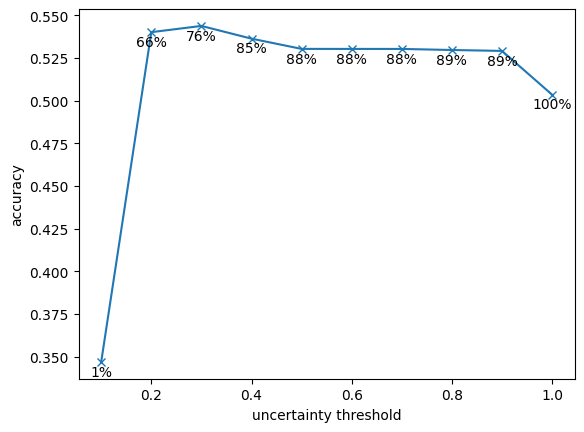

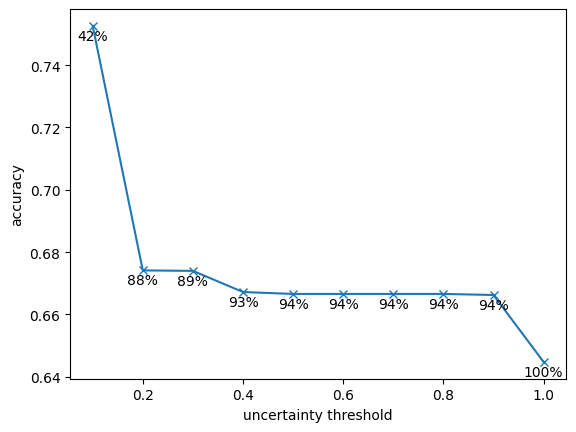

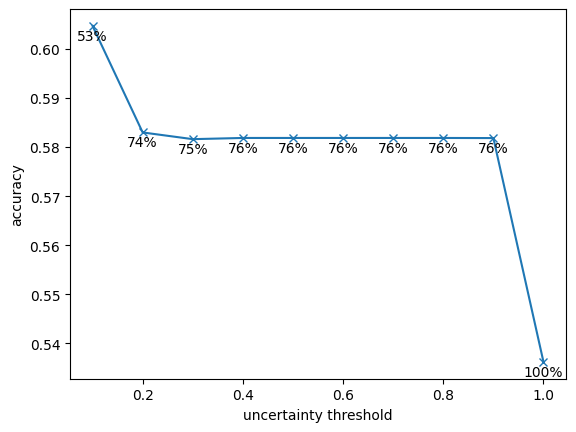

In [37]:
# singal model
result = {}
for i in range(len(model_names)):
    P = np.argmax(X[:,i*2:i*2+2], axis=1)
    U = 1 - np.max(X[:,i*2:i*2+2], axis=1) / 100
    PUT_data = np.column_stack((P, U, y))
    result[model_names[i]] = uncertainty_acc_result(model_names[i], PUT_data, cal = False)

In [40]:
test_S_avg

array([[56.66666667, 31.66666667],
       [ 0.        , 58.33333333],
       [56.66666667,  0.        ],
       ...,
       [ 0.        ,  0.        ],
       [58.33333333, 23.33333333],
       [26.66666667, 56.66666667]])

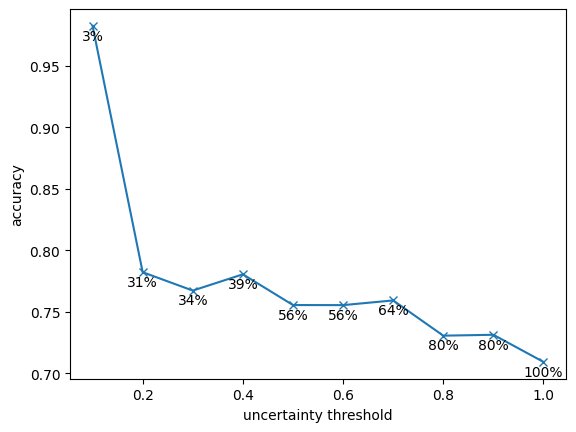

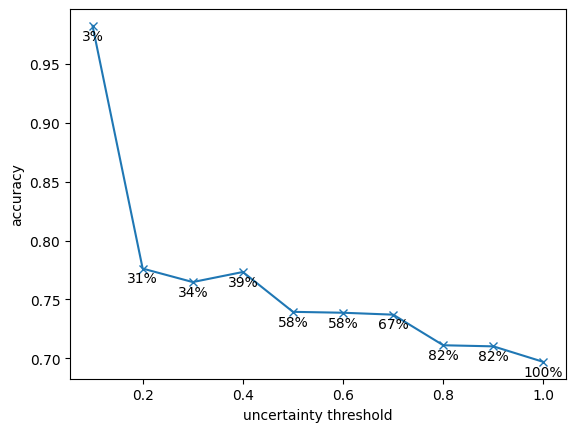

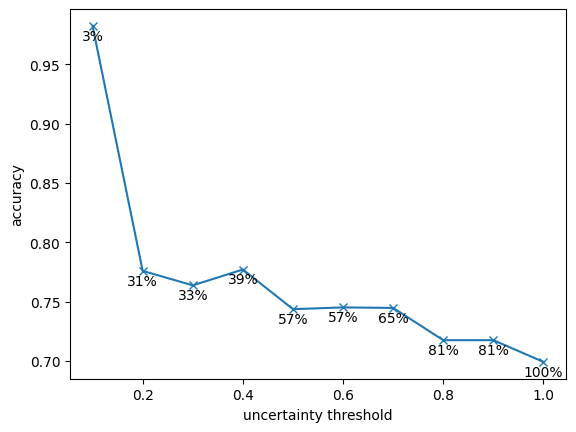

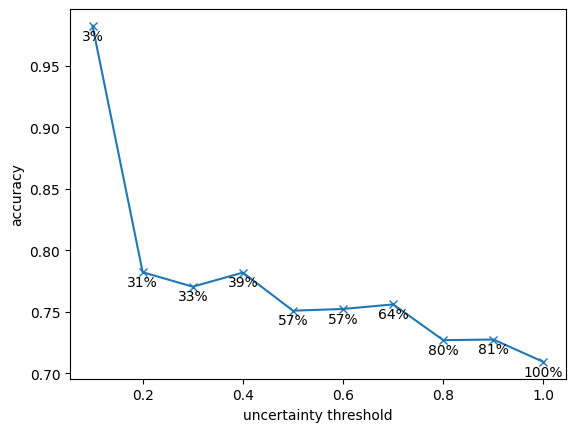

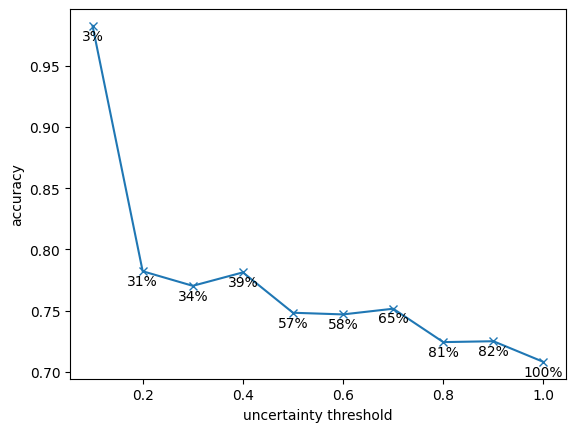

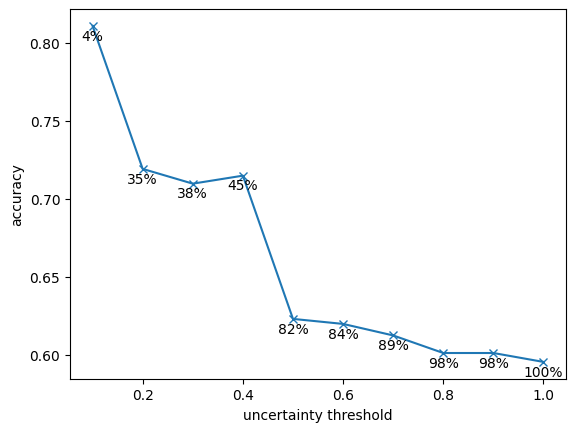

In [41]:
# dc_ml[args.models[4]] = X_test[:,4*8+6]
# for i in range(len(args.models)):
#     dc_ml[args.models[i]] = X_test[:,i*8+6]
# Yi_P = X_test[:,4*num_model_feature+col_model_pred].astype(int)
# # Yi_U = 1 - test_S_avg[np.arange(len(Yi_P)), Yi_P]
# dc_ml[args.models[4]] = (1,1,Yi_P)
# dc_ml.pop(args.models[4])
baseline_pred = np.argmax(test_S_avg, axis=1)
dc_ml['baseline'] = (f1_score(y_test, baseline_pred, average='macro'), accuracy_score(y_test, baseline_pred),baseline_pred)
result = {}
for method in ml_names:
    P = dc_ml[method][2].astype(int)
    U = 1 - test_S_avg[np.arange(len(P)), P]/100
    PUT_data = np.column_stack((P, U, y_test))
    result[method] = uncertainty_acc_result(method, PUT_data, cal = False)

# Yi_P = X_test[:,4*num_model_feature+col_model_pred].astype(int)
# Yi_U = X_test[:,4*num_model_feature+col_model_pred+1]
# PUT_data = np.column_stack((Yi_P, Yi_U, y_test))
# result['Yi_P'] = uncertainty_acc_result(method, PUT_data, cal = False)

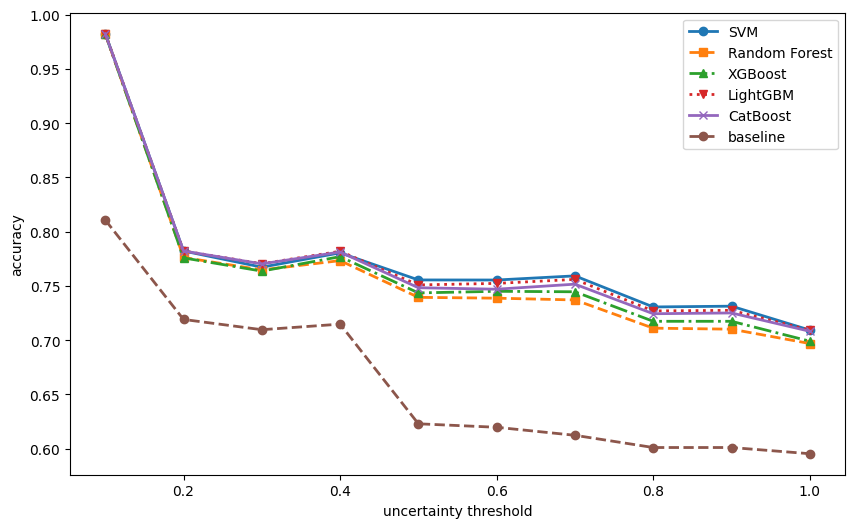

In [42]:
def plot_accuracy_multiple(models_results, title='Model Accuracy Comparison'):
    """
    models_results 是一个列表，包含多个 (model_name, results) 的元组。
    model_name 是字符串，results 是对应模型的 10行3列 二维数组。
    """
    plt.figure(figsize=(10, 6))  # 设置图像大小
    linestyles = ['-', '--', '-.', ':']  # 不同的线型
    markers = ['o', 's', '^', 'v', 'x']  # 不同的标记
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # 可选的颜色
    for i, model in enumerate(result):
        xs, ys, zs = models_results[model][:, 0], models_results[model][:, 1], models_results[model][:, 2]
        # # 为每个模型的每个点添加注释
        # for x, y, z in zip(xs, ys, zs):
        #     label = "{:.0f}%".format(100 * z)
        #     plt.annotate(label,  # 这个是标注的文本
        #                  (x, y),  # 这些是标注的坐标
        #                  textcoords="offset points",  # 文本的显示位置
        #                  xytext=(0, -10),  # 文本与点的距离
        #                  ha='center')  # 水平对齐方式
        # 使用不同的线型和标记，每次循环中循环使用它们
        plt.plot(xs, ys, label=model, 
                linestyle=linestyles[i % len(linestyles)],  # 循环使用线型
                marker=markers[i % len(markers)],  # 循环使用标记
                color=colors[i % len(colors)],  # 循环使用颜色
                markersize=6,  # 标记大小
                linewidth=2)  # 线宽
    plt.xlabel('uncertainty threshold')
    plt.ylabel('accuracy')
    plt.legend()  # 显示图例，区分不同模型
    plt.savefig(f'D:/git-code/updated_code/ollama_fact/figure/fv_comparison/{title}.png')
    plt.savefig(f'D:/git-code/updated_code/ollama_fact/figure/fv_comparison/{title}.svg')
    plt.show()
plot_accuracy_multiple(result,title=f'Model Accuracy Comparison')

In [43]:
result

{'SVM': array([[0.1       , 0.98245614, 0.03062869],
        [0.2       , 0.78222997, 0.30843632],
        [0.3       , 0.7672956 , 0.34175175],
        [0.4       , 0.78052126, 0.39172488],
        [0.5       , 0.75553417, 0.55830199],
        [0.6       , 0.75547098, 0.56475013],
        [0.7       , 0.75929054, 0.63621709],
        [0.8       , 0.73063973, 0.79795809],
        [0.9       , 0.73136333, 0.80010747],
        [1.        , 0.70929608, 1.        ]]),
 'Random Forest': array([[0.1       , 0.98245614, 0.03062869],
        [0.2       , 0.77624785, 0.31219774],
        [0.3       , 0.7648    , 0.33584095],
        [0.4       , 0.77335165, 0.39118753],
        [0.5       , 0.7394958 , 0.57549704],
        [0.6       , 0.73873045, 0.58409457],
        [0.7       , 0.73709677, 0.66630844],
        [0.8       , 0.71109652, 0.81837722],
        [0.9       , 0.71016393, 0.81945191],
        [1.        , 0.69693713, 1.        ]]),
 'XGBoost': array([[0.1       , 0.98245614, 0.030628

In [44]:
dc_f1_acc = {}
print("Model Comparison:")
for method in dc_ml.keys():
    dc_f1_acc[method] = (dc_ml[method][0], dc_ml[method][1])
# for i in range(len(args.models)):  
#     dc_f1_acc[args.models[i]] = (f1_score(y_test, X_test[:,i*num_model_feature+col_model_pred], average='macro'), accuracy_score(y_test, X_test[:,i*num_model_feature+col_model_pred]))
for id in dc_f1_acc.keys():
    print("F1-score: {:.4f}, Accuracy: {:.4f}   --{}".format(dc_f1_acc[id][0], dc_f1_acc[id][1], id))
    
result['f1_acc'] = dc_f1_acc
for key in result.keys():
    if isinstance(result[key],dict):
        continue
    result[key] = result[key].tolist()

with open(f'D:/git-code/updated_code/ollama_fact/json_file/fv_result_json/result.json', 'w') as file:
    json.dump(result, file, indent=4)

Model Comparison:
F1-score: 0.5246, Accuracy: 0.7093   --SVM
F1-score: 0.5382, Accuracy: 0.6969   --Random Forest
F1-score: 0.5277, Accuracy: 0.6991   --XGBoost
F1-score: 0.5256, Accuracy: 0.7093   --LightGBM
F1-score: 0.5120, Accuracy: 0.7082   --CatBoost
F1-score: 0.4745, Accuracy: 0.5244   --gemma2
F1-score: 0.4972, Accuracy: 0.6539   --gemma
F1-score: 0.5149, Accuracy: 0.5298   --mistral
F1-score: 0.4919, Accuracy: 0.5954   --baseline


In [166]:
dc_f1_acc = {}
for method in args.models:
    P = SPU[method].reshape(-1,SPU[method].shape[-1])[:,7].astype(int)
    dc_f1_acc[method] = (f1_score(y, P, average='macro'), accuracy_score(y, P))
result['f1_acc'] = dc_f1_acc
for key in result.keys():
    if isinstance(result[key],dict):
        continue
    result[key] = result[key].tolist()

with open(f'D:/git-code/updated_code/ollama_fact/json_file/result_json/result_single_model.json', 'w') as file:
    json.dump(result, file, indent=4)

In [173]:
with open('D:/git-code/updated_code/ollama_fact/json_file/result_json/'+'result_14model_S.json', 'r') as file:
    data_S = json.load(file)
data_S['f1_acc']

{'SVM': [0.8779045957200038, 0.8779],
 'Random Forest': [0.8798714829723187, 0.8799],
 'XGBoost': [0.8932791748220299, 0.8933],
 'LightGBM': [0.8868764944303285, 0.8869],
 'baseline': [0.7711031173238534, 0.7715]}

In [146]:
data['f1_acc']

{'SVM': [0.8583754208052579, 0.8584],
 'Random Forest': [0.8782711068732239, 0.8783],
 'XGBoost': [0.8945889299716457, 0.8946],
 'LightGBM': [0.888666604102998, 0.8887],
 'baseline': [0.7660844153755884, 0.7667],
 'Llama-2-7b-hf': [0.4520057132040955, 0.4538],
 'Qwen-1_8B': [0.4033973771791605, 0.4127],
 'falcon-7b': [0.21608881506495264, 0.2481],
 'internlm-7b': [0.4809624730267863, 0.4884],
 'Yi-34B': [0.8286136317032085, 0.8288],
 'Qwen-7B': [0.5927285651231905, 0.5939],
 'Qwen-14B': [0.739897744884987, 0.7405],
 'deepseek-llm-7b-base': [0.4312597428146766, 0.4388],
 'Yi-6B': [0.6999130089238268, 0.7005],
 'Qwen-72B': [0.7863862084604255, 0.7864],
 'mpt-7b': [0.2406173821640506, 0.2676],
 'deepseek-llm-67b-base': [0.7221257211043925, 0.7228],
 'Llama-2-13b-hf': [0.6038190230592068, 0.6046],
 'Llama-2-70b-hf': [0.7267398470988986, 0.727],
 'falcon-40b': [0.34887790631272697, 0.3508],
 'Mistral-7B-v0.1': [0.6408086826084838, 0.6416]}

In [154]:

def dict_to_latex_table(data):
    headers = ['model','F1-score','Accuracy']
    
    latex_code = "\\begin{tabular}{" + " | ".join(['c'] * len(headers)) + "}\n\\hline\n"
    latex_code += " & ".join(headers) + " \\\\\n\\hline\n"
    for key in data.keys():
        latex_code += key
        for i in data[key]:
            # print(i)
            latex_code += " & " + str(np.round(i,4))
        latex_code+= " \\\\\n"
    latex_code += "\\hline\n\\end{tabular}"
    return latex_code

# 将 dict 转换为 LaTeX 表格
latex_table = dict_to_latex_table(data_S['f1_acc'])

# 输出 LaTeX 表格代码
print(latex_table)


\begin{tabular}{c | c | c}
\hline
model & F1-score & Accuracy \\
\hline
SVM & 0.8794 & 0.8794 \\
Random Forest & 0.8795 & 0.8795 \\
XGBoost & 0.896 & 0.896 \\
LightGBM & 0.8896 & 0.8896 \\
baseline & 0.7661 & 0.7667 \\
\hline
\end{tabular}
